## ASTR 597A Homework 2
Eric Bellm

Due Jan 17, 2023

Your name: Tom Wagg
    
Your collaborators: David Wang, Jake Kurlander, Tobin Wainer

In [1]:
# Import general python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

### Setup

In [4]:
# create the TAP service client
service = get_tap_service()

In [5]:
# we will all use the same input coordinates and radii
center_coords = "62, -37"

As we saw in class, when we limit the number of rows returned from a query, we don't get the same set of rows returned each time.  It would be nice to choose a spatial region small enough to be able to load all of the records.  Let's count how many `isPrimary` objects there are at a fiducial radius:

In [6]:
radius_deg = 0.5

In [7]:
%%time
results = service.search("SELECT count(coord_ra)"
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                         "AND detect_isPrimary = 1 ").to_table()

print(results['count'])

count 
------
400406
CPU times: user 7.34 ms, sys: 1.61 ms, total: 8.95 ms
Wall time: 394 ms


Can we just "SELECT \*" and be on our way then?

## Exercise 1: Big Data


### Exercise 1a

How many `isPrimary` objects are in all of DP0.2?

In [8]:
# %%time
# results = service.search("SELECT count(coord_ra)"
#                          "FROM dp02_dc2_catalogs.Object "
#                          "WHERE detect_isPrimary = 1").to_table()
# print(results['count'])

We collectively got Jake to run the cell above whilst we worked on the rest because it took so long to run haha. We found that there are **161025835 isPrimary objects - that's more that 160 million!**

### Exercise 1b

How much memory do you need to load one row of the Object table?

*Hint: use the dtypes of all the columns.*

In [9]:
single_row = service.search("SELECT *"
                            "FROM dp02_dc2_catalogs.Object "
                            "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                            f"CIRCLE('ICRS', {center_coords}, {0.05})) = 1 "
                            "AND detect_isPrimary = 1 ", maxrec=1).to_table()

In [10]:
one_row_size = sum([x.itemsize for x in single_row.to_pandas().dtypes.values])
f'You need {one_row_size} bytes to load a single row'

'You need 4558 bytes to load a single row'

### Exercise 1c

What's the maximum number of full rows of the Object table can you load into a Medium instance on data.lsst.cloud?

In [11]:
# 6 GB of space in a medium instance
medium_instance = 6 * 2**30
max_rows = medium_instance / one_row_size
max_rows

1413438.1184730146

That only just over 1.4 million, _way_ fewer than the whole 161 million in the table, so we can't just load everything into memory any more :(

## Exercise 2: Scattered

When encountering a new dataset it is important to explore the data and understand its properties.  The tutorial notebook 02 will be a useful reference.  

(For the following exercises, use the `center_coords` and `radius_deg` defined above.)

### Exercise 2a: Star or galaxy?

What values can the `{band}_extendedness` entry take?  What fraction of the time do the values disagree between bands?  What if you only look at rows where none of the `{band}_extendedness_flag` are set?

2a (i): **`{band}_extendedness` can take the value of either 0 or 1**

In [12]:
columns = [f'{band}_{col}' for band in "ugrizy" for col in ["extendedness", "extendedness_flag"]]
columns += ["scisql_nanojanskyToAbMag(r_psfFlux) as r_psfMag",
            "scisql_nanojanskyToAbMagSigma(r_psfFlux, r_psfFluxErr) as r_psfMagErr",
            "r_psfFlux_flag"]

In [13]:
%%time
results = service.search(f"SELECT {','.join(columns)} "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         f"CIRCLE('ICRS', {center_coords}, {radius_deg})) = 1 "
                         "AND detect_isPrimary = 1 ").to_table()
df = results.to_pandas()

CPU times: user 13 s, sys: 245 ms, total: 13.3 s
Wall time: 16.8 s


In [14]:
%%time
all_equal = df.apply(lambda x: x.u_extendedness == x.g_extendedness == x.r_extendedness == x.i_extendedness == x.z_extendedness == x.y_extendedness,
                     axis=1)

CPU times: user 8 s, sys: 77 ms, total: 8.08 s
Wall time: 8.07 s


In [15]:
f"2a (ii): Approximately {1 - all_equal.sum() / len(all_equal):1.3f} of the time the values for band_extendedness disagree"

'2a (ii): Approximately 0.577 of the time the values for band_extendedness disagree'

In [16]:
no_flag_set = ~(df["u_extendedness_flag"] |
                df["g_extendedness_flag"] |
                df["r_extendedness_flag"] |
                df["i_extendedness_flag"] |
                df["z_extendedness_flag"] |
                df["y_extendedness_flag"])

In [17]:
f"2a (iii): Approximately {1 - all_equal[no_flag_set].sum() / len(all_equal[no_flag_set]):1.3f} of the time the values for band_extendedness disagree when no flag is set"

'2a (iii): Approximately 0.197 of the time the values for band_extendedness disagree when no flag is set'

So I think that this means that the flag is indicating when the band_extendedness values may not be trustworthy due to a "fatal failure".

### Exercise 2b. Signal to Noise

Make a plot of PSF magnitude vs. magnitude error for r-band point sources in our region of interest.  Exclude sources with the PSF Flux general failure flag set.  Set the axes extents to a reasonable range and label your axes!

Hints:  Consult the [schema browser](https://dm.lsst.org/sdm_schemas/browser/dp02.html#Object) for column names.  Consider using [hexbin](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html) instead of a scatter plot with `bins='log'`...

I cut the data at $r < 30$ as magnitudes past that didn't seem sensible and it kept the axes limits reasonable. I've also not seen `hexbin` before, I've always used `hist2d` previously, this is cool!

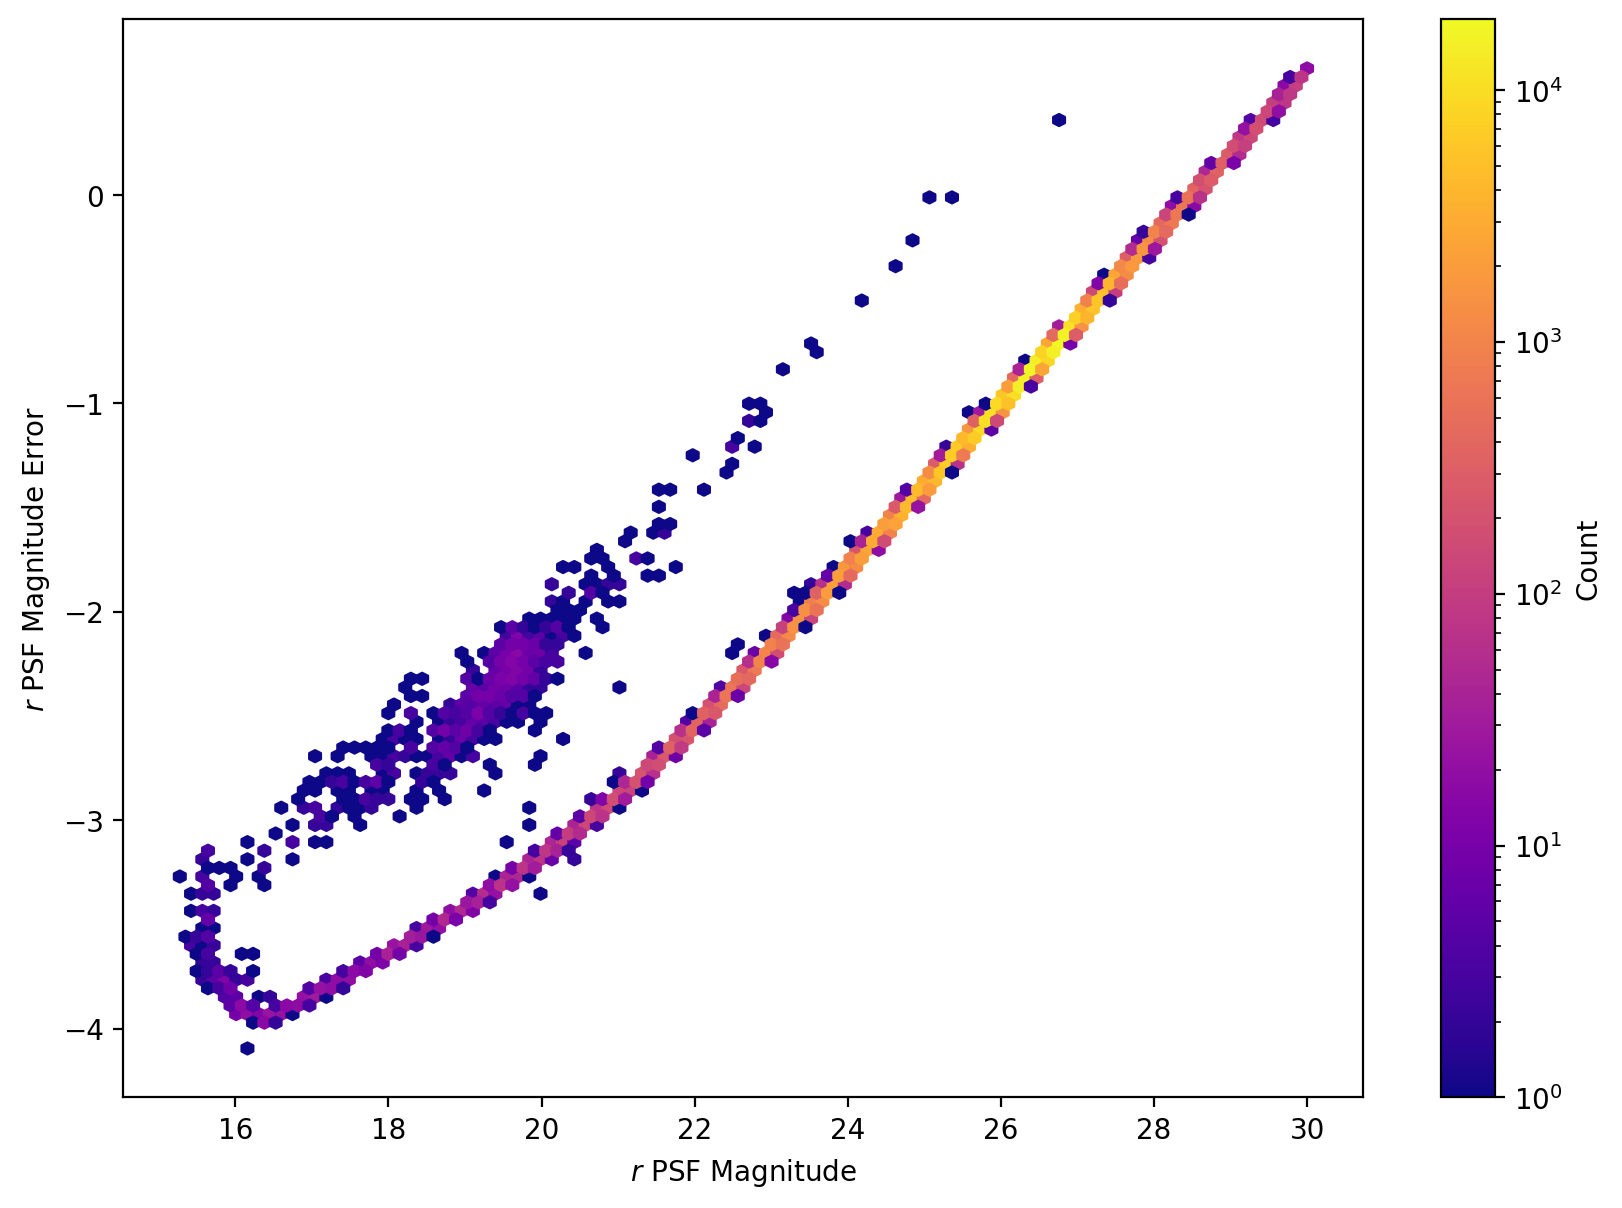

In [18]:
good_df = df[~df["r_psfFlux_flag"] & (df["r_psfMag"] < 30)]

fig, ax = plt.subplots(figsize=(10, 7))
hexs = ax.hexbin(good_df["r_psfMag"], np.log10(good_df["r_psfMagErr"]), bins='log', cmap="plasma", gridsize=100)

fig.colorbar(hexs, label="Count")

ax.set_xlabel(r"$r$ PSF Magnitude")
ax.set_ylabel(r"$r$ PSF Magnitude Error")

plt.show()

## Exercise 3: Find a Transient or Variable

Using the `DIAObject` table, find an object with more than 1 magnitude of variability and plot its lightcurve.  The 07a and 07b tutorial notebooks may be helpful.

In [19]:
%%time
results = service.search("SELECT diaObjectId "
                         "FROM dp02_dc2_catalogs.DiaObject "
                         "WHERE nDiaSources > 100 "
                         "AND scisql_nanojanskyToAbMag(rPSFluxMin)"
                         " - scisql_nanojanskyToAbMag(rPSFluxMax) > 1 ",
                         maxrec=100)
DiaObjs = results.to_table()
del results

CPU times: user 8.3 ms, sys: 1.96 ms, total: 10.3 ms
Wall time: 2.13 s


Originally I looped over a bunch of the IDs returned by the cell above. But I thought this one looked like it actually had some variations lining up across filters so I pull it out manually here

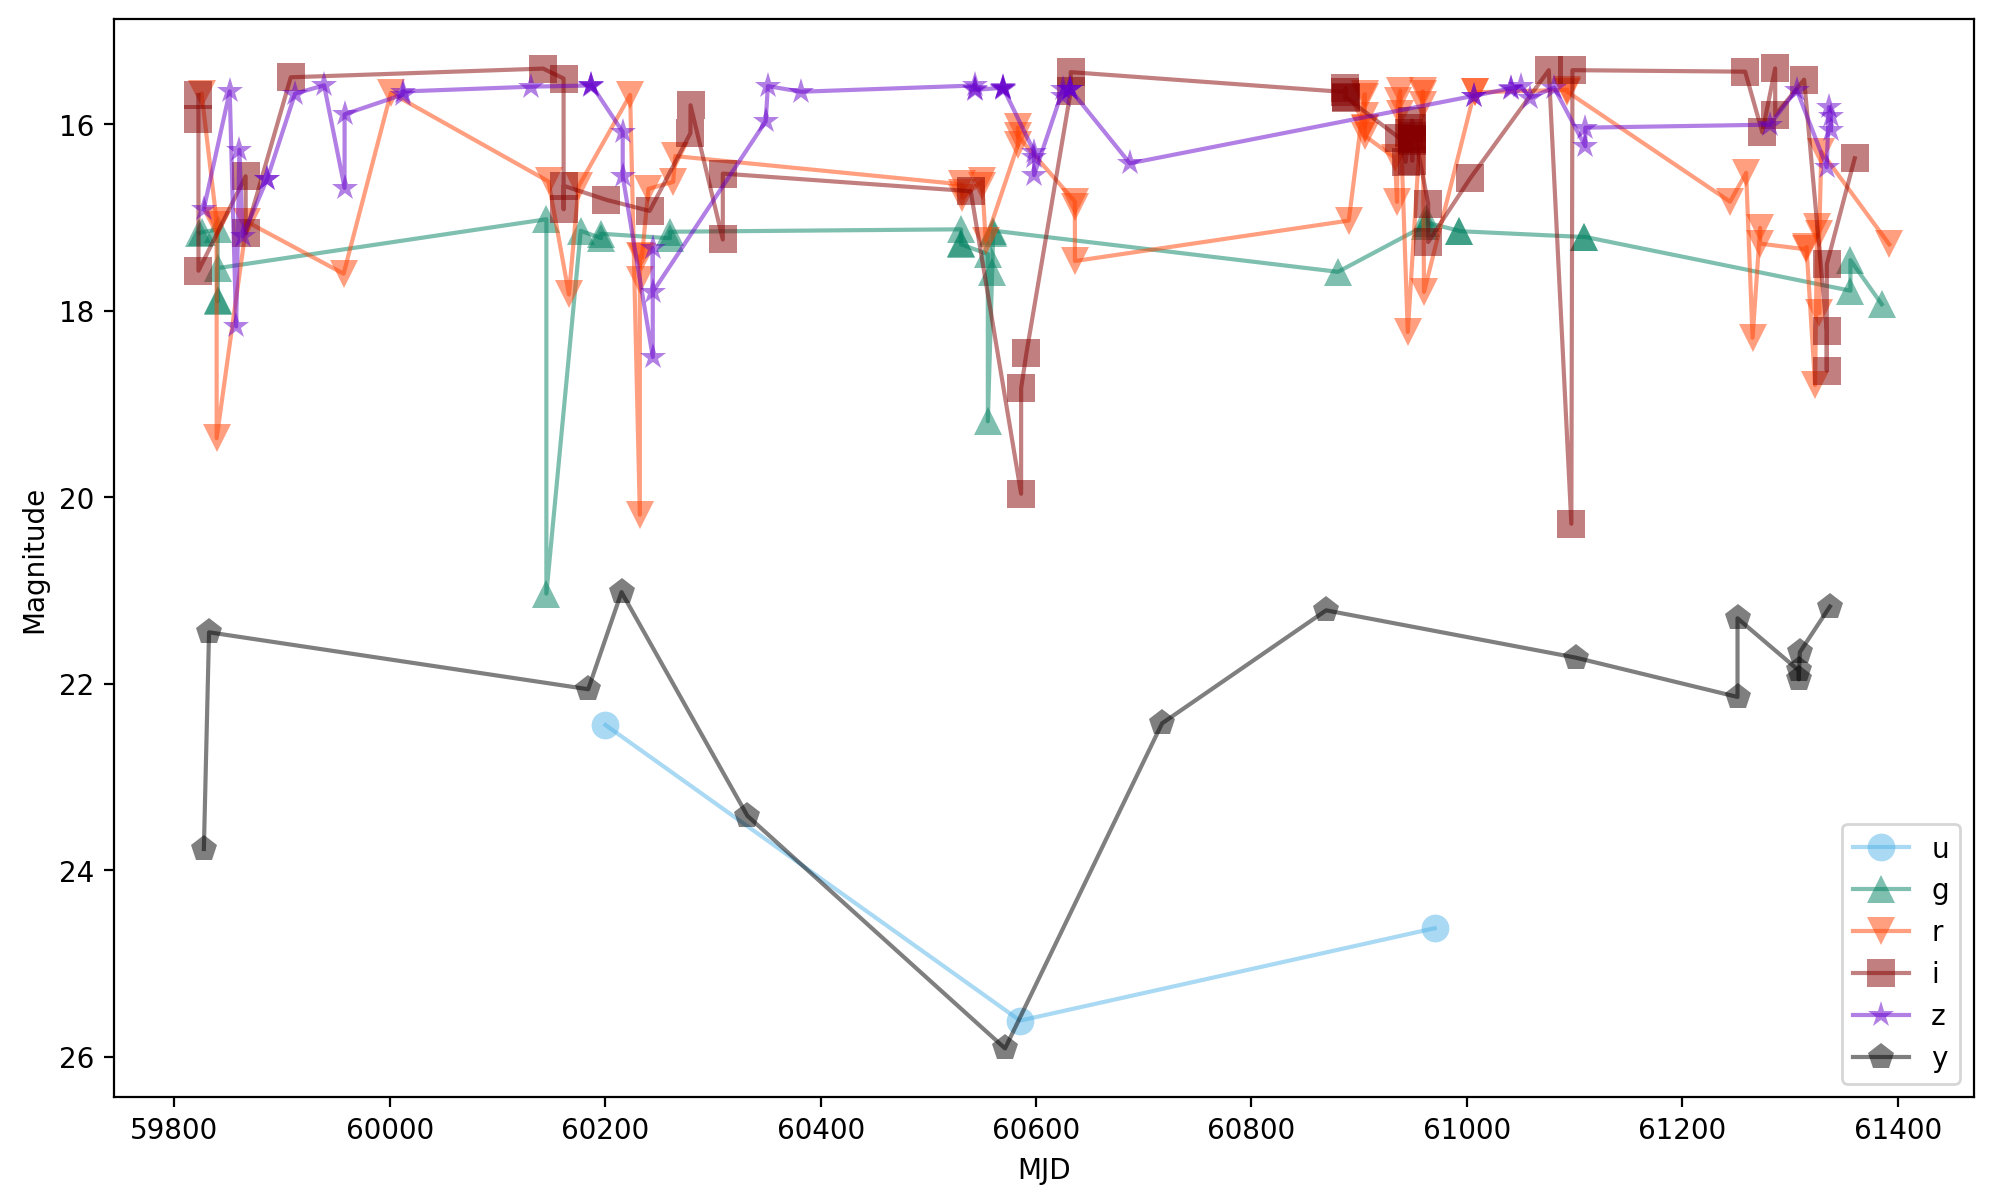

In [20]:
obj_id = "1249256315386069035"
# get lightcurve data
lc = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                    "filterName, midPointTai, "
                    "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                    "FROM dp02_dc2_catalogs.DiaSource "
                    f'WHERE diaObjectId = {obj_id}')

# convert to a dataframe (sort to make lines connect properly)
lcdf = lc.to_table().to_pandas().sort_values(by=["filterName", "midPointTai"])

fig, ax = plt.subplots(figsize=(12, 7))

for f, filt in enumerate(plot_filter_labels):
    # print(filt, lcdf[lcdf["filterName"] == filt]["midPointTai"])
    mask = (lcdf["filterName"] == filt) & ~np.isnan(lcdf['psAbMag'])
    plt.plot(lcdf['midPointTai'][mask],
             lcdf['psAbMag'][mask],
             marker=plot_filter_symbols[filt], ms=10, mew=0, alpha=0.5,
             color=plot_filter_colors[filt], label=filt)

plt.legend()
plt.gca().invert_yaxis()

plt.xlabel("MJD")
plt.ylabel("Magnitude")

plt.show()